In [1]:
# Import necessary libraries
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch


from torch import nn
from data import TimeFusionDataset
from timefusion import TimeFusion
from utils.metrics import variogram_score, crps_sum
from utils.modules import EarlyStopper

In [2]:
# Import dataset
train_data = pd.read_csv("../datasets/electricity/train.csv").set_index("date")
test_data = pd.read_csv("../datasets/electricity/test.csv").set_index("date")
train_data = train_data.iloc[:,:30]
test_data = test_data.iloc[:,:30]

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [4]:
context_length = 48
prediction_length = 24

# Create each dataset
train_dataset = TimeFusionDataset(
    data = train_data.iloc[:int(0.9*len(train_data))],
    context_length = context_length,
)
train_dataset.add_timestamp_encodings()

val_dataset = TimeFusionDataset(
    data = train_data.iloc[int(0.9*len(train_data)):],
    context_length = context_length,
)
val_dataset.add_timestamp_encodings()

test_dataset = TimeFusionDataset(
    data = test_data,
    context_length = context_length,
)
test_dataset.add_timestamp_encodings()

train_loader = DataLoader(
    dataset = train_dataset,
    shuffle = True,
    num_workers = 4,
    batch_size = 128,
)

val_loader = DataLoader(
    dataset = val_dataset,
    shuffle = True,
    num_workers = 4,
    batch_size = 128,
)



In [5]:
predictor = TimeFusion(
    prediction_length = prediction_length,
    input_size = train_dataset.tensor_data.shape[1],
    output_size = len(train_dataset.ts_columns),
    hidden_size = 60,
    recurrent_layers = 2,
    dropout = 0.0,
    residual_layers = 2,
    scaling = True,
    device = device,
    scaler_kwargs = {"scaled_rows":list(range(30))}
)

print("Number of trainable parameters:",sum(p.numel() for p in predictor.parameters()))

Number of trainable parameters: 89094


/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timefusion/diffusion.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bar_alphas = torch.tensor(


In [6]:
optimizer = torch.optim.Adam(params=predictor.parameters(),lr=5e-4)
lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.01, total_iters=40)

predictor.train_network(
    train_loader = train_loader,
    epochs=40,
    val_loader = val_loader,
    val_metrics= {
        "Val MAE": nn.L1Loss(),
    },
    optimizer = optimizer,
    lr_scheduler= lr_scheduler,
    early_stopper=EarlyStopper(patience=10),
    save_weights = True,
    weight_folder = "weights"
)

 |==============================|  Batch: 170 / 170, Epoch: 1 / 40, Average Loss: 0.6453, Val MAE: 0.4377, val_loss: 0.3450


In [11]:
# Loading weights
predictor.load_state_dict(torch.load("weights/2023-05-16-18-09-05"))
predictor.eval()

TimeFusion(
  (scaler): MeanScaler()
  (diff_embedding): DiffusionEmbedding(
    (projection1): Linear(in_features=32, out_features=32, bias=True)
    (tanh1): Tanh()
    (projection2): Linear(in_features=32, out_features=32, bias=True)
  )
  (rnn): LSTM(38, 60, num_layers=2, batch_first=True)
  (linear1): Linear(in_features=122, out_features=122, bias=True)
  (linear2): Linear(in_features=122, out_features=122, bias=True)
  (linear3): Linear(in_features=122, out_features=30, bias=True)
  (relu): ReLU()
)

Plots for idx: 0
Plots for idx: 50
Plots for idx: 100


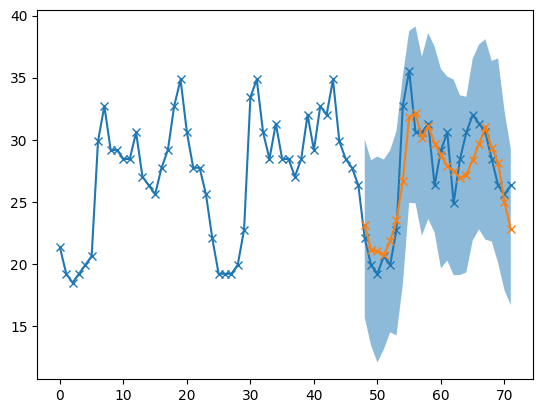

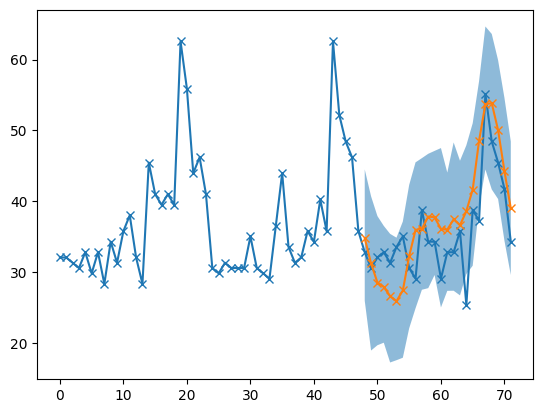

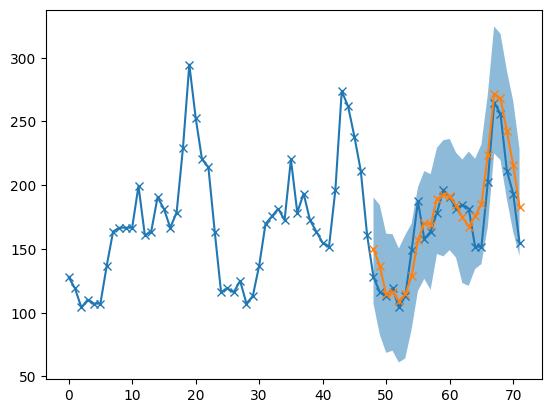

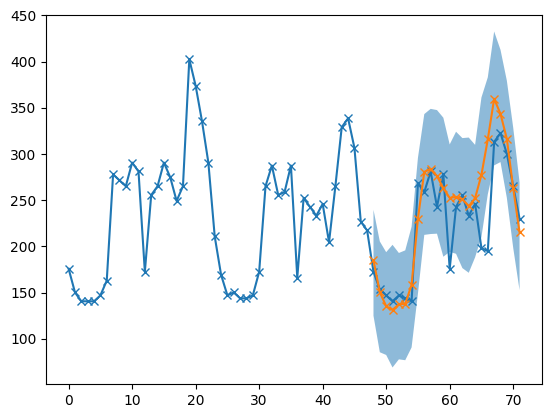

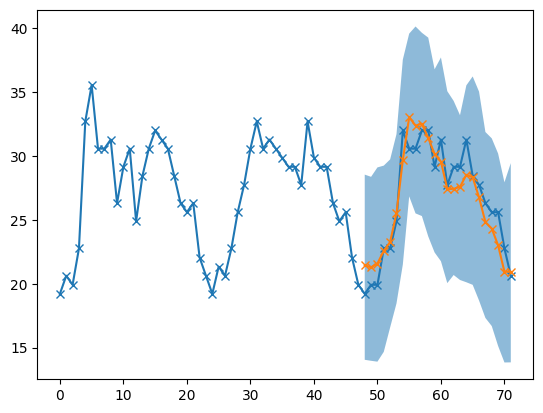

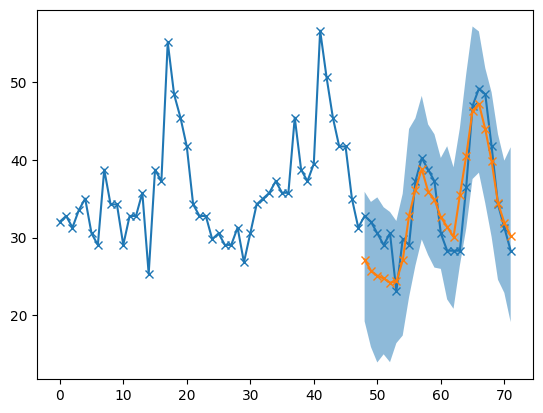

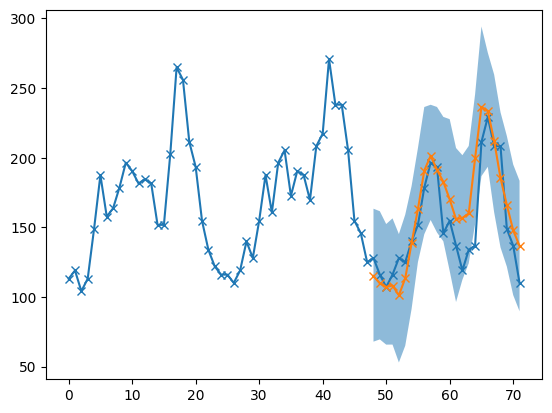

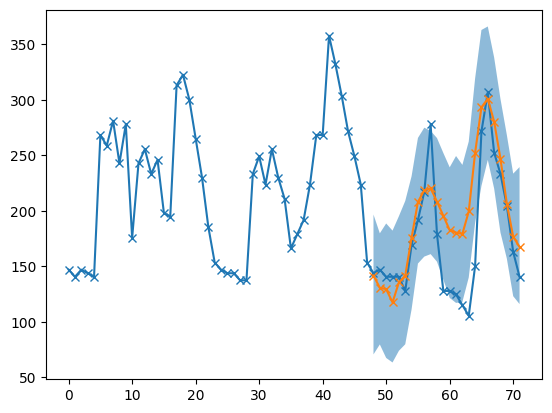

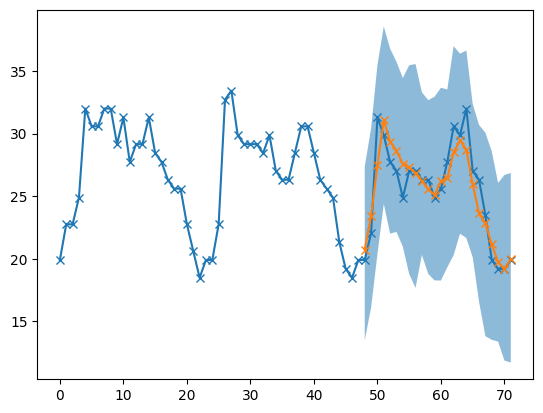

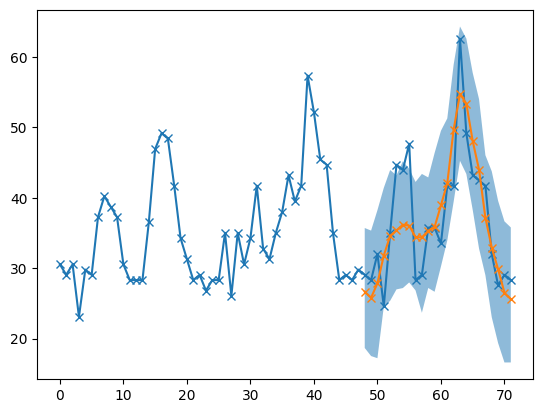

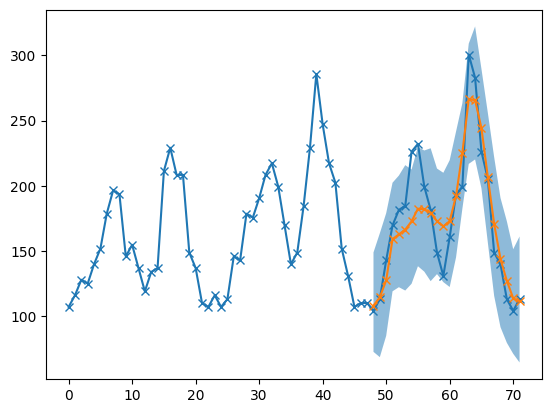

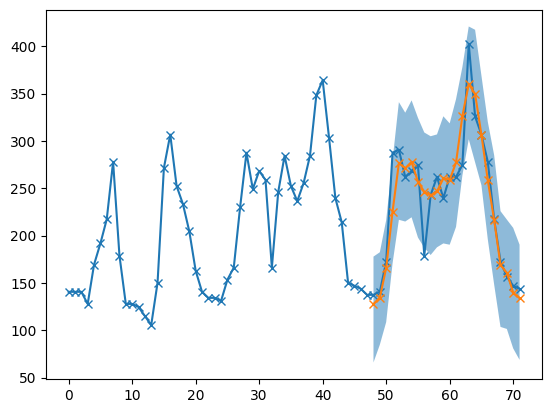

In [12]:
idx = 0
for idx in {0,50,100}:
    print(f"Plots for idx: {idx}")

    samples = predictor.sample(
        data = test_dataset,
        idx = idx,
        num_samples = 128,
        batch_size = 128
    )

    confidence = 0.1
    samples_cpu = samples.cpu()
    for i in range(samples_cpu.shape[1]):
        samples_cpu[:,i,:], _ = torch.sort(samples_cpu[:,i,:], dim=0)

    for ts in {1,5,10,15}:
        plt.figure()
        plt.plot(list(range(context_length + prediction_length)),test_dataset.tensor_data[idx:idx+context_length+prediction_length,ts],"-x")
        plt.plot(list(range(context_length,context_length+prediction_length)),torch.mean(samples_cpu[:,ts],dim = 0),"-x")
        plt.fill_between(list(range(context_length,context_length+prediction_length)), samples_cpu[int(confidence*samples_cpu.shape[0]),ts], samples_cpu[int((1-confidence)*samples_cpu.shape[0]),ts],alpha=0.5)


In [17]:
# Sample for first two weeks of test data
samples = []
for i in range(14):
    idx = 24*i

    samples.append(
        predictor.sample(
            data = test_dataset,
            idx = idx,
            num_samples = 256,
            batch_size = 128
        ).cpu()
    )

samples = torch.cat([x.unsqueeze(0) for x in samples], dim = 0)

realisations = []
for i in range(14):
    idx = 24*i

    realisations.append(
        test_dataset.tensor_data[context_length + idx:idx + context_length + prediction_length,test_dataset.ts_columns].T
    )

realisations = torch.cat([x.unsqueeze(0) for x in realisations], dim = 0)

In [30]:
realisations.shape

torch.Size([14, 30, 24])

In [36]:
# Get numerical values for performance of network
from sklearn.metrics import mean_absolute_error, median_absolute_error

# MAE and MdAE of average prediction
mae = mean_absolute_error(realisations.flatten(), torch.mean(samples,dim=1).flatten())
mdae = median_absolute_error(realisations.flatten(), torch.mean(samples,dim=1).flatten())
print(f"MAE: {mae}, MDAE: {mdae}")


# Variogram and CRPS_SUM
flat_samples = samples.permute((1,0,2,3))
flat_samples = flat_samples.flatten(1,2)
flat_realisations = realisations.flatten(0,1)
var_score = variogram_score(flat_realisations.numpy(), flat_samples.numpy(),**{"weights":"local","window_size":3})
crps_score = crps_sum(flat_realisations.numpy(), flat_samples.numpy())

print(var_score,crps_score)

MAE: 8.391098976135254, MDAE: 3.946359634399414


In [32]:
flat_samples = samples.permute((0,2,1,3))
flat_samples = flat_samples.flatten(0,1)
flat_realisations = realisations.flatten(0,1)

In [10]:
realisations = []
for col in range(test_dataset.indices.shape[1]):
    realisations.append(test_dataset.data_copy.iloc[sample_index:,col].dropna()[:test_dataset.prediction_length])
realisations = np.array(realisations)

predictions = np.array(samples.cpu())

# Calculate metrics
var_score = variogram_score(realisations,predictions,**{"weights":"local","window_size":5})
crps_score = crps_sum(realisations,predictions)

print(var_score,crps_score)

AttributeError: 'TimeFusionDataset' object has no attribute 'indices'